In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import Autoencoder
from utils import train_autoencoder, load_mnist

from utils import knn_impute_image, mean_impute_image

In [4]:
train_data, test_data = load_mnist()

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [5]:
ae = Autoencoder()

optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
ae.load_state_dict(torch.load('../checkpoints/autoencoder.pt'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cuda')

In [6]:
# losses = train_autoencoder(
#     ae,
#     train_loader,
#     optimizer,
#     loss_fn,
#     epochs=100,
#     device=device
# )

Epoch 1/100: average loss = 0.0601
Epoch 2/100: average loss = 0.0319
Epoch 3/100: average loss = 0.0230
Epoch 4/100: average loss = 0.0197
Epoch 5/100: average loss = 0.0180
Epoch 6/100: average loss = 0.0165
Epoch 7/100: average loss = 0.0153
Epoch 8/100: average loss = 0.0143
Epoch 9/100: average loss = 0.0136
Epoch 10/100: average loss = 0.0130
Epoch 11/100: average loss = 0.0125
Epoch 12/100: average loss = 0.0121
Epoch 13/100: average loss = 0.0119
Epoch 14/100: average loss = 0.0116
Epoch 15/100: average loss = 0.0113
Epoch 16/100: average loss = 0.0111
Epoch 17/100: average loss = 0.0109
Epoch 18/100: average loss = 0.0107
Epoch 19/100: average loss = 0.0106
Epoch 20/100: average loss = 0.0104
Epoch 21/100: average loss = 0.0103
Epoch 22/100: average loss = 0.0101
Epoch 23/100: average loss = 0.0100
Epoch 24/100: average loss = 0.0099
Epoch 25/100: average loss = 0.0098
Epoch 26/100: average loss = 0.0097
Epoch 27/100: average loss = 0.0096
Epoch 28/100: average loss = 0.0095
E

In [9]:
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist.pth")

In [10]:
# random imputer
def mcar_mask_image(img, missing_rate=0.2):
    if img.dim() == 3:
        C, H, W = img.shape
        mask = torch.rand(C, H, W, device=img.device) > missing_rate
    elif img.dim() == 4:
        B, C, H, W = img.shape
        mask = torch.rand(B, C, H, W, device=img.device) > missing_rate

    masked_img = img.clone()
    masked_img[~mask] = float("nan")

    return masked_img, mask

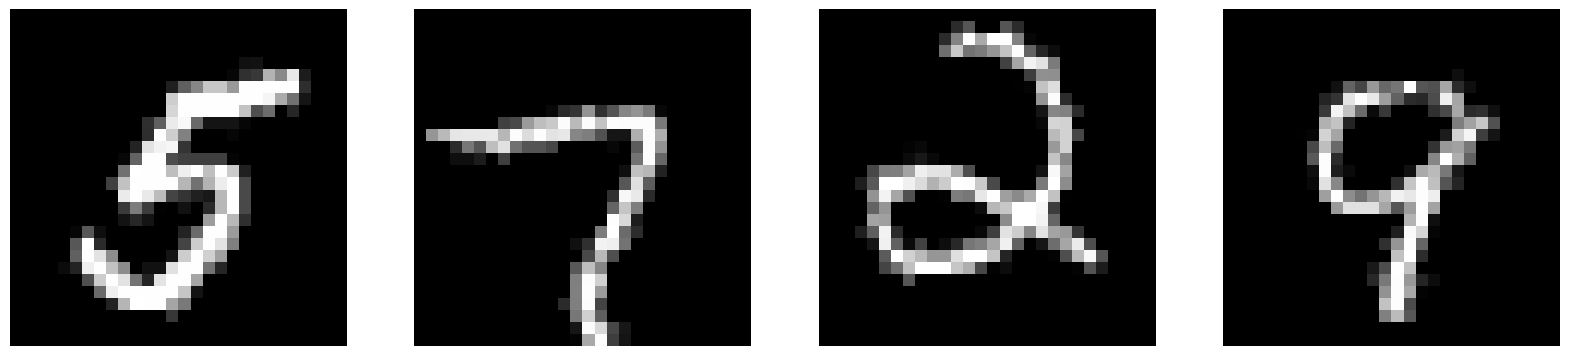

In [11]:
idx = torch.randint(len(train_data), size=(4,1)).numpy()
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, index in enumerate(idx):
    img, label = train_data[index.item()]

    # Mask and impute pixels
    masked_img, mask = mcar_mask_image(img, missing_rate=0.25)
    # imputed_img = mean_impute_image(masked_img)
    imputed_img = knn_impute_image(masked_img)

    axs[i].imshow(imputed_img.squeeze(), cmap="gray")
    axs[i].axis('off')

plt.show()

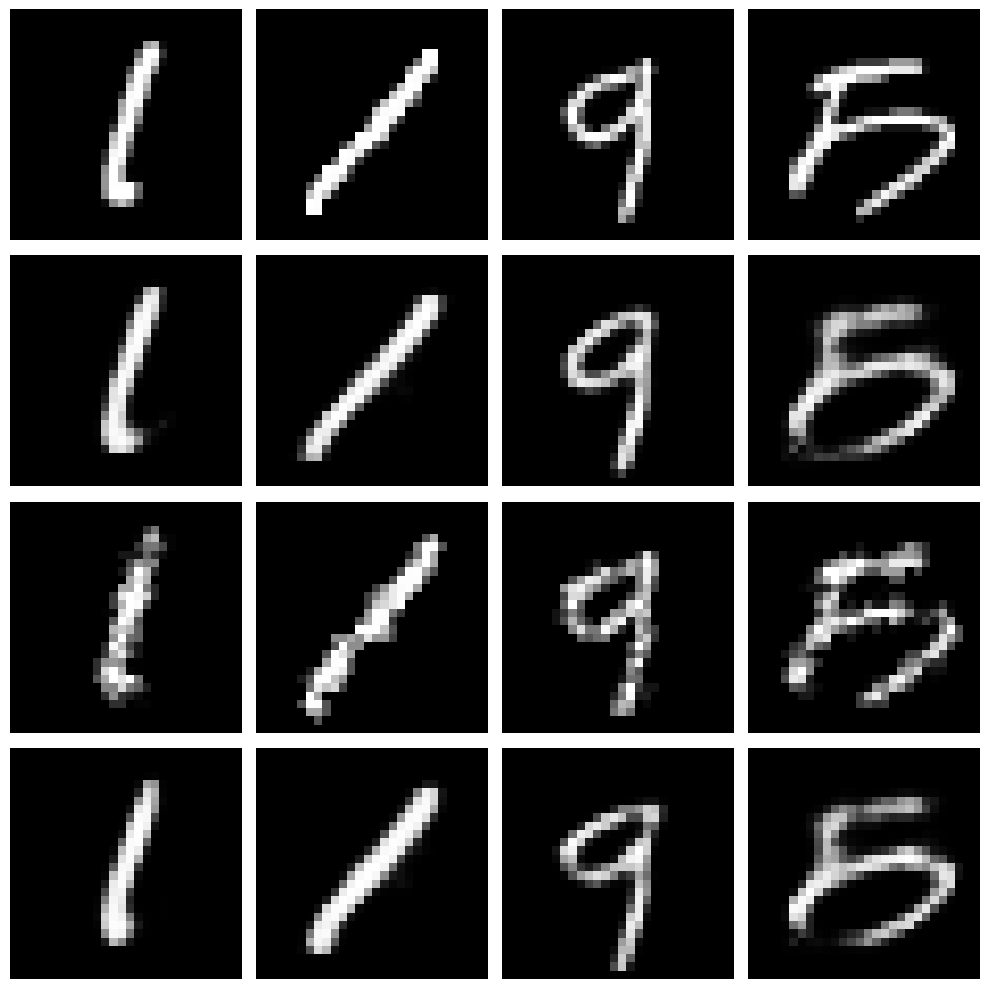

In [14]:
idx = torch.randint(len(train_data), size=(4,1)).numpy()
ae.eval()

fig, axs = plt.subplots(4, 4, figsize=(10, 10))


for i, index in enumerate(idx):
    img, label = train_data[index.item()]

    masked_img, mask = mcar_mask_image(img, missing_rate=0.50)
    # imputed_img = mean_impute_image(masked_img)
    imputed_img = knn_impute_image(masked_img)

    img = img.squeeze()

    reconstructed_img, latent = ae(img.view(784).to(device))
    reconstructed_corrupted, corrupted_latent = ae(imputed_img.view(784).to(device))


    axs[0][i].imshow(img, cmap="gray")
    axs[0][i].axis('off')

    axs[1][i].imshow(reconstructed_img.detach().cpu().view(28, 28), cmap="gray")
    axs[1][i].axis('off')

    axs[2][i].imshow(imputed_img.squeeze(), cmap="gray")
    axs[2][i].axis('off')

    axs[3][i].imshow(reconstructed_corrupted.detach().cpu().view(28, 28), cmap="gray")
    axs[3][i].axis('off')


fig.tight_layout()
plt.show()